In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.datasets import macrodata

# Load macroeconomic data
data = macrodata.load_pandas().data
df = data[["realgdp", "realcons", "realinv"]]
df.index = pd.date_range(start='1959-03-31', periods=len(df), freq='Q')

<ipython-input-1-3836c70bb076>:11: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  df.index = pd.date_range(start='1959-03-31', periods=len(df), freq='Q')


In [2]:
# First differencing to remove trends
df_diff = df.diff().dropna()

In [3]:
# Keep last 12 quarters for testing
n_obs = 12
train = df_diff[:-n_obs]
test = df_diff[-n_obs:]

In [4]:
model = VAR(train)
results = model.fit(maxlags=15, ic='aic')  # Automatically chooses best lag using AIC

In [5]:
lag_order = results.k_ar
forecast_input = train.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=n_obs)

# Convert to DataFrame
forecast_df = pd.DataFrame(forecast, index=test.index, columns=test.columns)

In [6]:
# Get last actual value before forecast
last_actual = df.iloc[-n_obs - 1]
forecast_actual = forecast_df.cumsum() + last_actual

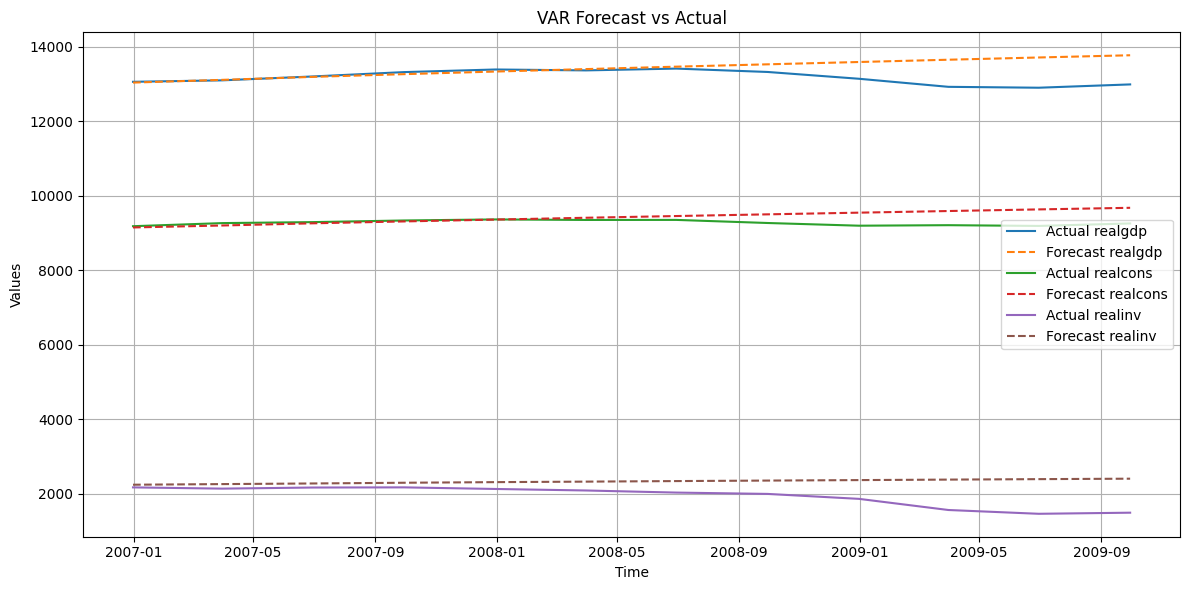

In [16]:
plt.figure(figsize=(12, 6))
for col in df.columns:
    plt.plot(df.index[-n_obs:], df[col].iloc[-n_obs:], label=f"Actual {col}")
    plt.plot(forecast_actual.index, forecast_actual[col], '--', label=f"Forecast {col}")
plt.title("VAR Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [8]:
for col in df.columns:
    rmse = np.sqrt(mean_squared_error(df[col].iloc[-n_obs:], forecast_actual[col]))
    print(f"RMSE for {col}: {rmse:.2f}")

RMSE for realgdp: 414.24
RMSE for realcons: 244.27
RMSE for realinv: 498.64
